# readme
descrip: plot total, mean and eddy fluxes <br> 

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
steps: <br>
1. finalize UET+VNT depth integration plot
2. interp temp from T grids to U grids 
3. compute 

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

# incorporate dask 

In [2]:
client = Client("tcp://10.73.1.122:45395")
client

<Client: 'tcp://10.73.1.249:44742' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200+50, 700-50 
nlat1_r_t12, nlat2_r_t12 = 1300+100, 2000-100

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ===========================================================

In [4]:
# read TH UET, VNT 

# --- read one file ---
# infile_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UET/'
#                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.UET.195001-195012.nc')
# chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ds_uet_TH = xr.open_dataset(infile_uet_TH, chunks=chunks_HR)
# ds_uet_r_TH = ds_uet_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_uet_r_TH.UET.isel(time=0,z_t=0).where(ds_uet_r_TH.KMT>0).plot()
# ds_uet_TH 

# infile_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNT/'
#                  'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.VNT.195001-195012.nc')

# ds_vnt_TH = xr.open_dataset(infile_vnt_TH, chunks=chunks_HR)
# ds_vnt_r_TH = ds_vnt_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_vnt_r_TH.VNT.isel(time=0,z_t=0).where(ds_vnt_r_TH.KMT>0).plot()
# ds_vnt_TH 
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UET/')
infiles1a_uet_TH = [indir1a_uet_TH + prefix1a_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uet_TH

indir1a_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNT/')
infiles1a_vnt_TH = [indir1a_vnt_TH + prefix1a_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vnt_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UET/')
infiles2_uet_TH = [indir1b_uet_TH + prefix2_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uet_TH

indir1b_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VNT/')
infiles2_vnt_TH = [indir1b_vnt_TH + prefix2_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vnt_TH


ds_uet_TH = xr.open_mfdataset(infiles1a_uet_TH + infiles2_uet_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vnt_TH = xr.open_mfdataset(infiles1a_vnt_TH + infiles2_vnt_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vnt_TH first time: ', ds_vnt_TH.time[0].values)
print('ds_vnt_TH end time: ', ds_vnt_TH.time[-1].values)
print('ds_vnt_TH # time: ', len(ds_vnt_TH.time))
#ds_vnt_TH

ds_vnt_TH first time:  2001-02-01 00:00:00
ds_vnt_TH end time:  2101-01-01 00:00:00
ds_vnt_TH # time:  1200


In [5]:
# read U, V vel TH 

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-200612.nc')
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uvel_TH

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-200612.nc')
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vvel_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_vvel_TH first time: ', ds_vvel_TH.time[0].values)
print('ds_vvel_TH end time: ', ds_vvel_TH.time[-1].values)
print('ds_vvel_TH # time: ', len(ds_vvel_TH.time))

ds_vvel_TH first time:  2001-02-01 00:00:00
ds_vvel_TH end time:  2101-01-01 00:00:00
ds_vvel_TH # time:  1200


In [6]:
# read TEMP TH

# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_temp_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/TEMP/')
infiles1a_temp_TH = [indir1a_temp_TH + prefix1a_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_temp_TH

yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_temp_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/TEMP/')
infiles2_temp_TH = [indir1b_temp_TH + prefix2_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_temp_TH

ds_temp_TH = xr.open_mfdataset(infiles1a_temp_TH + infiles2_temp_TH, compat="override", combine="by_coords", 
                             data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_temp_TH time[0]', ds_temp_TH.time[0].values)
print('ds_temp_TH time[-1]', ds_temp_TH.time[-1].values)
print('ds_temp_TH # time', len(ds_temp_TH.time))
ds_temp_TH # temp unit: degC

ds_temp_TH time[0] 2001-02-01 00:00:00
ds_temp_TH time[-1] 2101-01-01 00:00:00
ds_temp_TH # time 1200


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    TEMP                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Wed Aug 25 23:38:21 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [7]:

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.UVEL.195001-195012.nc')
# # chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks=chunks_HR)
# ds_uvel_r_TH = ds_uvel_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_uvel_r_TH.UVEL.isel(time=0,z_t=0).where(ds_uvel_r_TH.KMT>0).plot()
# ds_uvel_TH 

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.VVEL.195001-195012.nc')
# # chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks=chunks_HR)
# ds_vvel_r_TH = ds_vvel_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_vvel_r_TH.VVEL.isel(time=0,z_t=0).where(ds_uvel_r_TH.KMT>0).plot()
# ds_vvel_TH 
# ----------------------

In [9]:
# # read temp
# infile_temp_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/TEMP/'
#                   'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.195001-195012.nc')
# # chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
# ds_temp_TH = xr.open_dataset(infile_temp_TH, chunks=chunks_HR)
# ds_temp_r_TH = ds_temp_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))
# ds_temp_r_TH.TEMP.isel(time=0,z_t=0).where(ds_uvel_r_TH.KMT>0).plot()
# ds_temp_TH 

<xarray.DataArray 'HDIFT' (time: 1, nlat: 384, nlon: 320)>
[122880 values with dtype=float32]
Coordinates:
  * time     (time) object 2006-01-01 00:00:00
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertically Integrated Horz Mix T tendency
    units:         centimeter degC/s
    grid_loc:      2110
    cell_methods:  time: mean

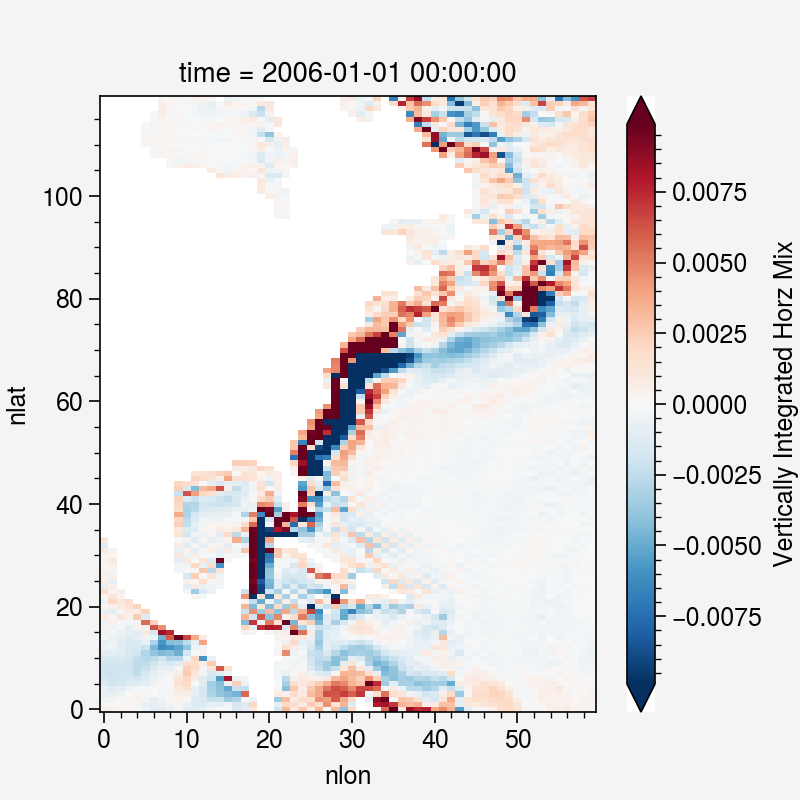

In [37]:
infile_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/'
          'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.2005-12.nc')
ds_TL = xr.open_dataset(infile_TL)#, chunks=chunks_LR
# HDIFT
ds_TL.HDIFT.isel(time=0,nlon=slice(nlon1_r_g16, nlon2_r_g16), nlat=slice(nlat1_r_g16, nlat2_r_g16)).plot(robust=True)
ds_TL.HDIFT

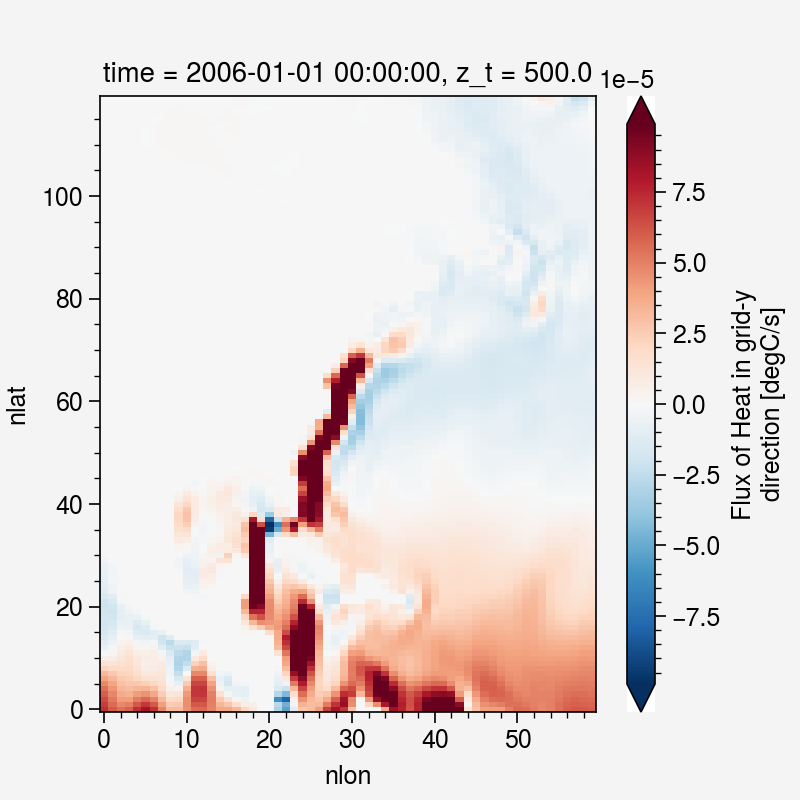

In [41]:
ds_TL.VNT.isel(time=0,z_t=0, nlon=slice(nlon1_r_g16, nlon2_r_g16), nlat=slice(nlat1_r_g16, nlat2_r_g16)).plot(robust=True)

In [14]:
infile = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/daily/'
          'cmpr_B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.nday1.2005-12-01.nc')

ds = xr.open_dataset(infile, chunks=chunks_HR)
ds

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 31, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                (time) object 2005-12-02 00:00:00 ... 2006-01-01 00:0...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/91)
    time_bound          (time, d2) object dask.array<chunksize=(31, 2), meta=np.ndarray>
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    W23_23              (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
    W34_34              (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
    W41_41              (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
    QFLUX               (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
    HMXL                (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
    HBLT                (time, nlat, nlon) float32 dask.array<chunksize=(31, 400, 300), meta=np.ndarray>
Attributes:
    title:           B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:         none
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:        All years have exactly  365 days.
    start_time:      This dataset was created on 2020-03-20 at 08:24:29.8
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    35511827
    tavg_sum:        86400.0
    tavg_sum_qflux:  86400.0

In [18]:
# ds.U1_1#.isel(time=0).plot()

<xarray.DataArray 'U1_1' (time: 31, nlat: 2400, nlon: 3600)>
dask.array<open_dataset-b344dab5654958e8d43a62100d87aa1aU1_1, shape=(31, 2400, 3600), dtype=float32, chunksize=(31, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-12-02 00:00:00 ... 2006-01-01 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Zonal Velocity lvls 1-1
    units:         centimeter/s
    grid_loc:      2221
    cell_methods:  time: mean

In [7]:
# supplimentary files 
# infile0_LR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_LR = xr.open_dataset(infile0_LR)
# ds0_LR

# infile0_HR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_HR = xr.open_dataset(infile0_HR)
# ds0_HR

infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                       nlat=slice(nlat1_r_t12, nlat2_r_t12))
ds_r_g16 = ds_g16.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                       nlat=slice(nlat1_r_g16, nlat2_r_g16))
ds_3dDZT_t12

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, z_t: 62)
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    DZT      (z_t, nlat, nlon) float64 ...

# data analysis

In [9]:
ds_uet_TH['VNT'] = ds_vnt_TH.VNT
ds_uet_TH['UVEL'] = ds_uvel_TH.UVEL
ds_uet_TH['VVEL'] = ds_vvel_TH.VVEL
ds_uet_TH['TEMP'] = ds_temp_TH.TEMP
ds_uet_TH['DZT'] = ds_3dDZT_t12.DZT*100
ds_uet_TH['DZU'] = ds_3dDZU_t12.DZU*100

time_s_TH = ds_uet_TH.time.to_pandas().index.shift(-1,'D')
time_s_TH
ds_uet_TH = ds_uet_TH.assign_coords(time=time_s_TH)

In [10]:
# convert to xgcm object
# copied by DL on 2022Jan07 from https://github.com/NCAR/pop-tools/blob/master/docs/source/examples/pop_div_curl_xr_xgcm_metrics_compare.ipynb ===
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],  # areas, technically not needed
}


# xgcm metrics
# gridm, xdsm = pop_tools.to_xgcm_grid_dataset(ds, periodic=False, metrics=metrics)
grid_uet_TH, xds_uet_TH = pop_tools.to_xgcm_grid_dataset(ds_uet_TH, metrics=metrics)
xds_uet_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 2400, nlat_u: 2400, nlon_t: 3600, nlon_u: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2
Data variables: (12/57)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    VNT                 (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    UVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    VVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    TEMP                (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    DZT                 (z_t, nlat_t, nlon_t) float64 nan nan nan ... nan nan
    DZU                 (z_t, nlat_u, nlon_u) float64 nan nan nan ... nan nan
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 12:21:43 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [11]:
kmt_r_TH = xds_uet_TH.KMT.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))
kmt_r_TH 

<xarray.DataArray 'KMT' (nlat_t: 500, nlon_t: 400)>
dask.array<getitem, shape=(500, 400), dtype=float64, chunksize=(300, 300), chunktype=numpy.ndarray>
Coordinates:
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 50), meta=np.ndarray>
  * nlon_t   (nlon_t) float64 250.5 251.5 252.5 253.5 ... 647.5 648.5 649.5
  * nlat_t   (nlat_t) float64 1.4e+03 1.402e+03 1.402e+03 ... 1.898e+03 1.9e+03
Attributes:
    long_name:  k Index of Deepest Grid Cell on T Grid
    grid_loc:   2110

In [14]:
# budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
# budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)

uet_TH = -grid_uet_TH.diff(xds_uet_TH.UET, axis="X")
uet_r_TH = uet_TH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))

vnt_TH = -grid_uet_TH.diff(xds_uet_TH.VNT, axis="Y")
vnt_r_TH = vnt_TH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))

velt_div_r_TH = (uet_r_TH + vnt_r_TH)
velt_div_intz_r_TH = (velt_div_r_TH*xds_uet_TH.DZT).sum('z_t')
velt_div_intz_r_TH

<xarray.DataArray (time: 1200, nlat_t: 700, nlon_t: 500)>
dask.array<sum-aggregate, shape=(1200, 700, 500), dtype=float64, chunksize=(12, 399, 299), chunktype=numpy.ndarray>
Coordinates:
  * nlat_t   (nlat_t) float64 1.3e+03 1.302e+03 1.302e+03 ... 1.998e+03 2e+03
  * nlon_t   (nlon_t) float64 200.5 201.5 202.5 203.5 ... 697.5 698.5 699.5
  * time     (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:00:00
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>

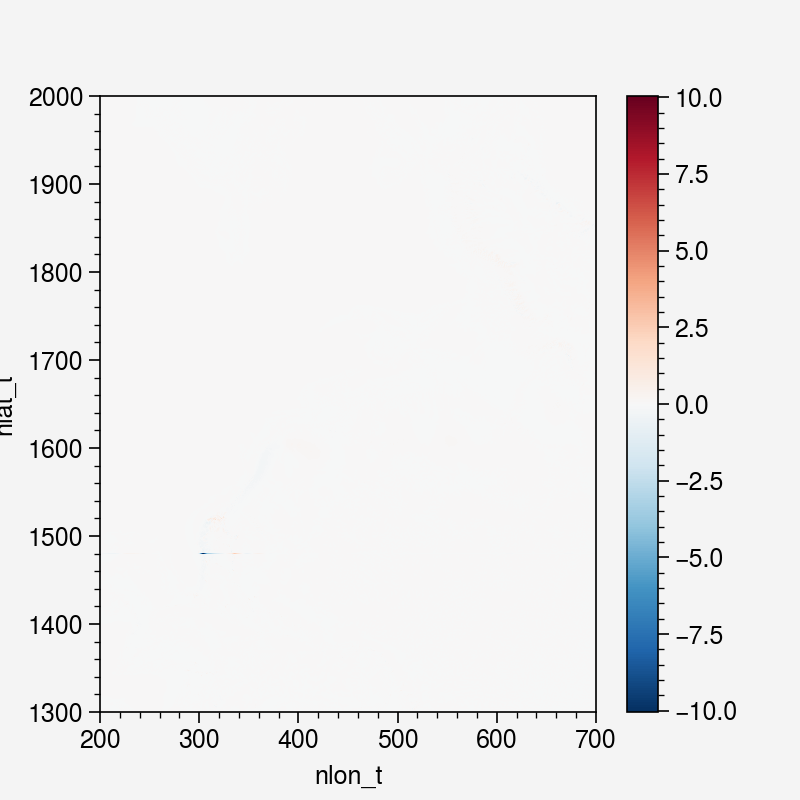

In [18]:
velt_div_intz_t1_r_TH = velt_div_intz_r_TH.isel(time=slice(0,12*20)).mean('time').persist()
# velt_div_intz_t1_r_TH.plot()

In [22]:
print(velt_div_intz_r_TH.isel(time=slice(-12*20,None)).time)
velt_div_intz_t2_r_TH = velt_div_intz_r_TH.isel(time=slice(-12*20,None)).mean('time').persist()

<xarray.DataArray 'time' (time: 240)>
array([cftime.datetime(2081, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2081, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2081, 4, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       ...,
       cftime.datetime(2100, 11, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2100, 12, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2101, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2081-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


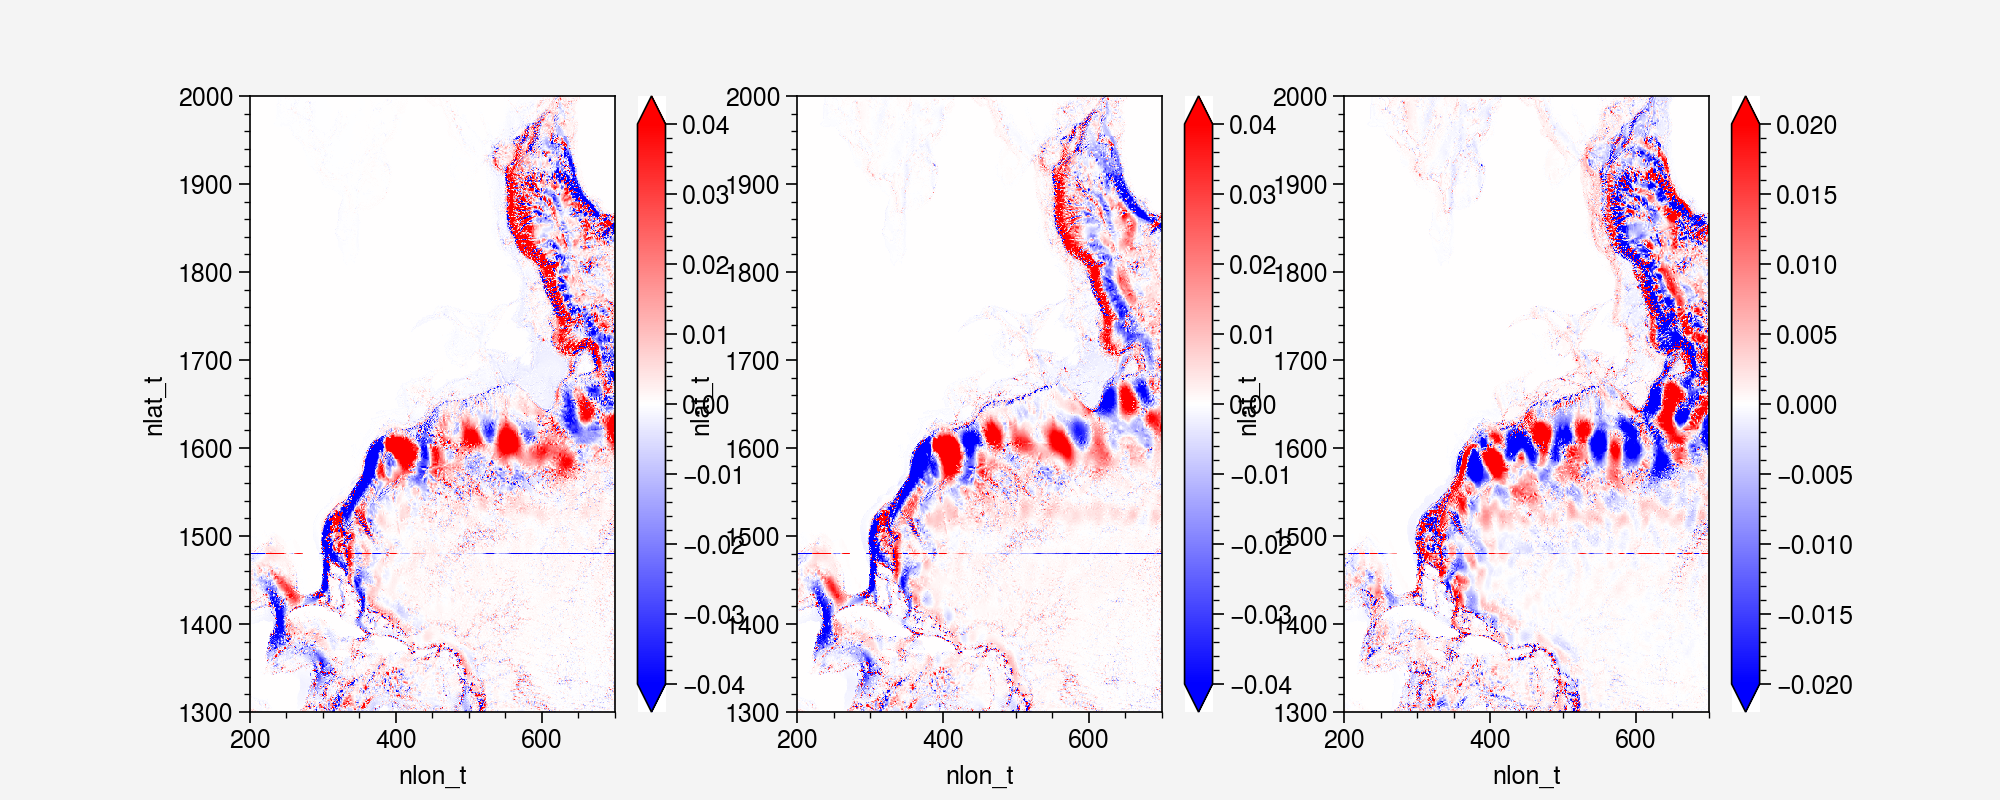

In [29]:
fig, axs = plt.subplots(1,3,figsize=(10,4))
velt_div_intz_t1_r_TH.plot(ax=axs[0], vmin=-0.04, vmax=0.04, cmap='bwr')
velt_div_intz_t2_r_TH.plot(ax=axs[1], vmin=-0.04, vmax=0.04, cmap='bwr')
(velt_div_intz_t2_r_TH - velt_div_intz_t1_r_TH).plot(ax=axs[2], vmin=-0.02, vmax=0.02, cmap='bwr')

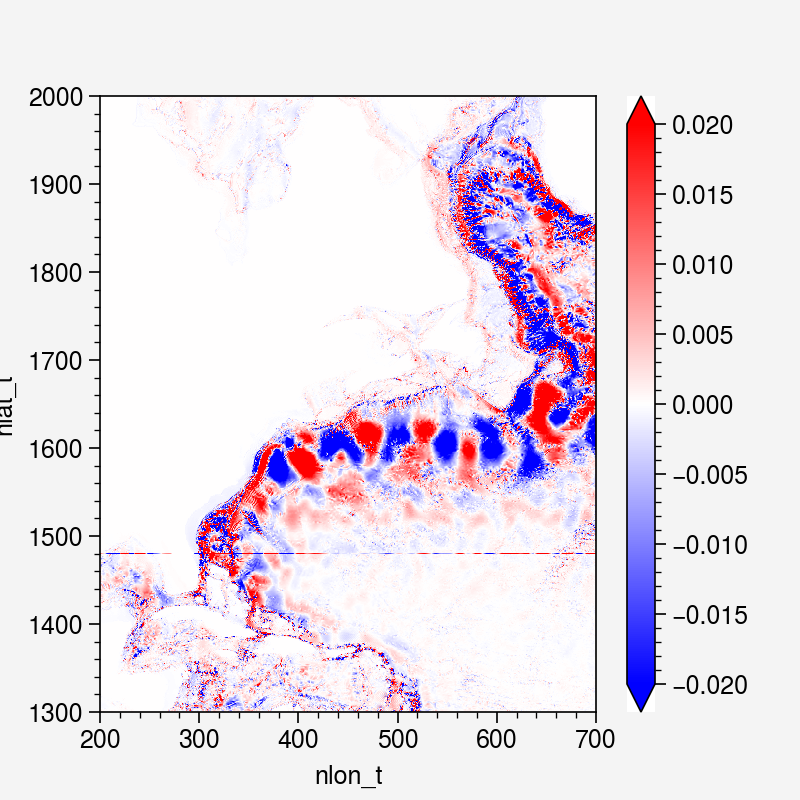

In [30]:
(velt_div_intz_t2_r_TH - velt_div_intz_t1_r_TH).plot(vmin=-0.02, vmax=0.02, cmap='bwr')

In [21]:
print(velt_div_intz_r_TH.isel(time=slice(-12*20, None)).time)
velt_div_intz_t2_r_TH = velt_div_intz_r_TH.isel(time=slice(-12*20, None)).mean('time').persist()

<xarray.DataArray 'time' (time: 240)>
array([cftime.datetime(2081, 2, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2081, 3, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2081, 4, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       ...,
       cftime.datetime(2100, 11, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2100, 12, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True),
       cftime.datetime(2101, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2081-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bound


In [20]:
time_s_TH = velt_div_intz_r_TH.time.to_pandas().index.shift(-1,'D')
time_s_TH
velt_div_intz_r_TH = velt_div_intz_r_TH.assign_coords(time=time_s_TH)
velt_div_intz_tre_r_TH = velt_div_intz_r_TH.resample(time='A').mean('time')
velt_div_intz_tre_r_TH = velt_div_intz_tre_r_TH.persist()
velt_div_intz_tre_r_TH 

<xarray.DataArray (time: 100, nlat_t: 700, nlon_t: 500)>
dask.array<stack, shape=(100, 700, 500), dtype=float64, chunksize=(1, 399, 299), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
  * nlat_t   (nlat_t) float64 1.3e+03 1.302e+03 1.302e+03 ... 1.998e+03 2e+03
  * nlon_t   (nlon_t) float64 200.5 201.5 202.5 203.5 ... 697.5 698.5 699.5
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>

In [21]:
velt_div_intz_tre_r_TH.isel(time=0).plot()

KeyboardInterrupt: 

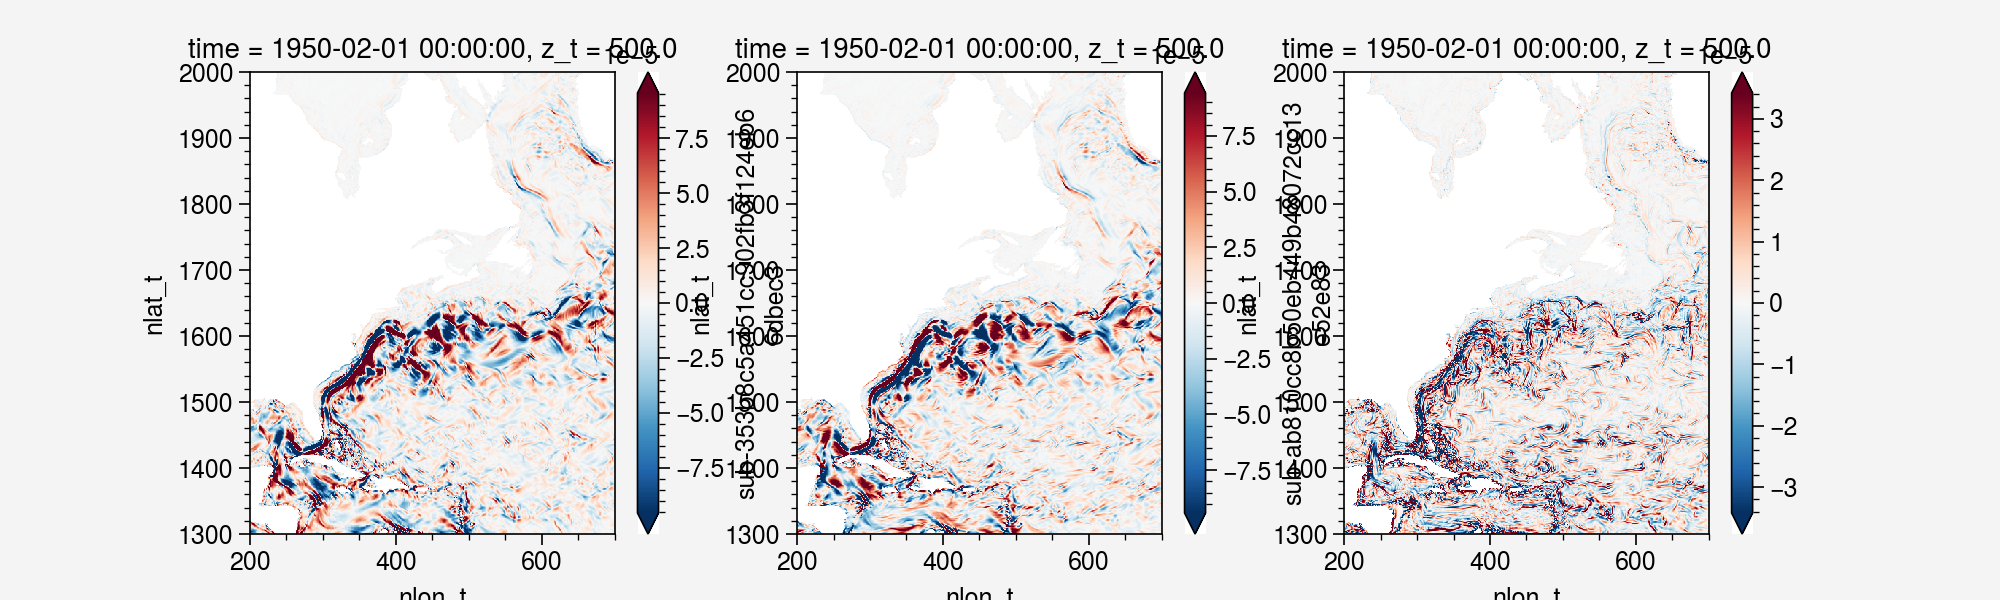

In [22]:
# budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
# budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)

uet_TH = -grid_uet_TH.diff(xds_uet_TH.UET, axis="X")
uet_r_TH = uet_TH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))

vnt_TH = -grid_uet_TH.diff(xds_uet_TH.VNT, axis="Y")
vnt_r_TH = vnt_TH.isel(nlon_t=slice(nlon1_r_t12, nlon2_r_t12), nlat_t=slice(nlat1_r_t12, nlat2_r_t12))


fig, axs = plt.subplots(1,3,figsize=(10,3))
uet_r_TH.isel(time=0,z_t=0).where(kmt_r_TH>0).plot(ax=axs[0], robust=True)
vnt_r_TH.isel(time=0,z_t=0).where(kmt_r_TH>0).plot(ax=axs[1], robust=True)
(uet_r_TH+vnt_r_TH).isel(time=0,z_t=0).where(kmt_r_TH>0).plot(ax=axs[2], robust=True)

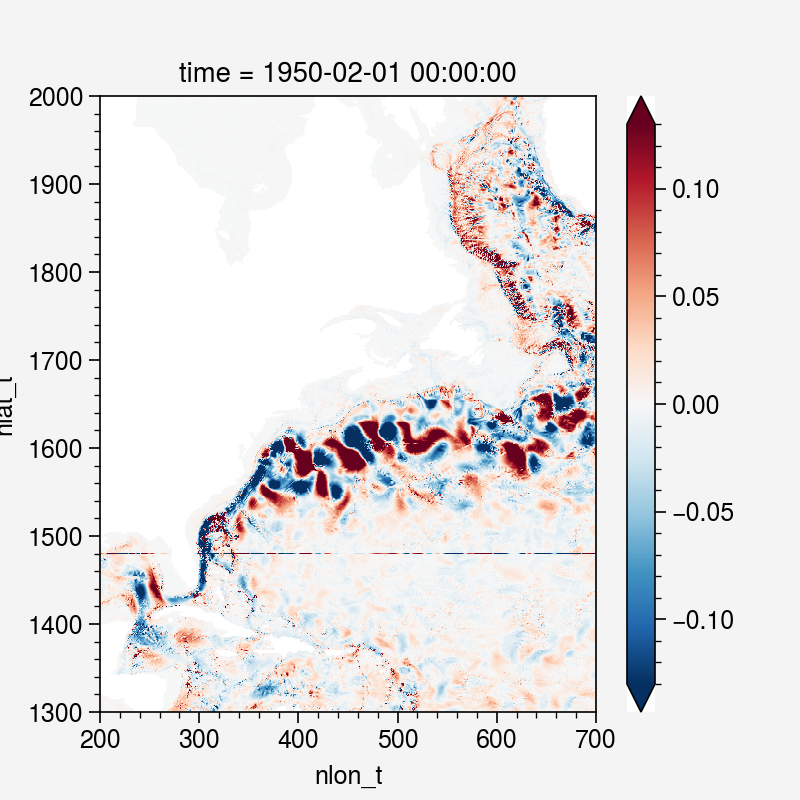

In [27]:
((uet_r_TH+vnt_r_TH)*xds_uet_TH.DZT).sum('z_t').isel(time=0).where(kmt_r_TH>0).plot(robust=True)

In [18]:
ds_tot_TH = ds_uet_TH 
ds_tot_TH['TOT'] = ds_uet_TH.UET + ds_vnt_TH.VNT
ds_tot_TH['DZT'] = ds_3dDZT_t12.DZT*100
ds_tot_TH

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 12, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/54)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UET                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    VNT                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    TOT                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    DZT                 (z_t, nlat, nlon) float64 nan nan nan ... nan nan nan
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 11:28:07 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-25 at 15:43:24.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  22795331
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [19]:
grid, xds_tot_TH = pop_tools.to_xgcm_grid_dataset(ds_tot_TH)
print(grid)
xds_tot_TH

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   nlon_t --> right
  * right    nlon_u --> center
Y Axis (periodic, boundary=None):
  * center   nlat_t --> right
  * right    nlat_u --> center
Z Axis (periodic, boundary=None):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center


<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlat_t: 2400, nlat_u: 2400, nlon: 3600, nlon_t: 3600, nlon_u: 3600, time: 12, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 ... 3596 3597 3598 3599 3600
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 ... 2396 2397 2398 2399 2400
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 ... 3.598e+03 3.6e+03
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 ... 2.398e+03 2.4e+03
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/54)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UET                 (time, z_t, nlat_t, nlon_u) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    VNT                 (time, z_t, nlat_u, nlon_t) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    TOT                 (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
    DZT                 (z_t, nlat_t, nlon_t) float64 nan nan nan ... nan nan
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 11:28:07 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-25 at 15:43:24.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  22795331
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [ ]:
ds["DZT"] = ds_3dDZT_t12.DZT
ds["DZU"] = ds_3dDZU_t12.DZU

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds_g.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

In [25]:
grid_r, xds_temp_r_TH = pop_tools.to_xgcm_grid_dataset(ds_temp_r_TH, periodic=False)
print(grid_r)
xds_temp_r_TH

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center
Y Axis (not periodic, boundary=None):
  * center   nlat_t --> right
  * right    nlat_u --> center
X Axis (not periodic, boundary=None):
  * center   nlon_t --> right
  * right    nlon_u --> center


<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 700, nlat_u: 700, nlon_t: 500, nlon_u: 500, time: 12, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
  * time                (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 7 ... 495 496 497 498 499 500
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 7 ... 695 696 697 698 699 700
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 3.5 ... 497.5 498.5 499.5
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 3.5 ... 697.5 698.5 699.5
Dimensions without coordinates: d2
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    TEMP                (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 1, 300, 100), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Wed Aug 25 22:53:44 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-25 at 15:43:24.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  22795331
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [28]:
grid_uvel_r, xds_uvel_r_TH = pop_tools.to_xgcm_grid_dataset(ds_uvel_r_TH, periodic=False)
print(grid_uvel_r)
xds_uvel_r_TH

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   z_t --> left
  * right    z_w_bot --> center
  * left     z_w_top --> center
Y Axis (not periodic, boundary=None):
  * center   nlat_t --> right
  * right    nlat_u --> center
X Axis (not periodic, boundary=None):
  * center   nlon_t --> right
  * right    nlon_u --> center


<xarray.Dataset>
Dimensions:             (d2: 2, nlat_t: 700, nlat_u: 700, nlon_t: 500, nlon_u: 500, time: 12, z_t: 62, z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/13)
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ULAT                (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ...                  ...
    TLAT                (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
  * time                (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:0...
  * nlon_u              (nlon_u) int64 1 2 3 4 5 6 7 ... 495 496 497 498 499 500
  * nlat_u              (nlat_u) int64 1 2 3 4 5 6 7 ... 695 696 697 698 699 700
  * nlon_t              (nlon_t) float64 0.5 1.5 2.5 3.5 ... 497.5 498.5 499.5
  * nlat_t              (nlat_t) float64 0.5 1.5 2.5 3.5 ... 697.5 698.5 699.5
Dimensions without coordinates: d2
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w_top) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    KMU                 (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    UAREA               (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    UVEL                (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 1, 300, 100), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 19:38:04 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-25 at 15:43:24.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  22795331
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [29]:
xds_uvel_r_TH.UVEL

<xarray.DataArray 'UVEL' (time: 12, z_t: 62, nlat_u: 700, nlon_u: 500)>
dask.array<getitem, shape=(12, 62, 700, 500), dtype=float32, chunksize=(12, 1, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
  * time     (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:00:00
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 693 694 695 696 697 698 699 700
Attributes:
    long_name:     Velocity in grid-x direction
    units:         centimeter/s
    grid_loc:      3221
    cell_methods:  time: mean

In [27]:
xds_temp_r_TH.TEMP

<xarray.DataArray 'TEMP' (time: 12, z_t: 62, nlat_t: 700, nlon_t: 500)>
dask.array<getitem, shape=(12, 62, 700, 500), dtype=float32, chunksize=(12, 1, 400, 300), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(300, 100), meta=np.ndarray>
  * time     (time) object 1950-02-01 00:00:00 ... 1951-01-01 00:00:00
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 696.5 697.5 698.5 699.5
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

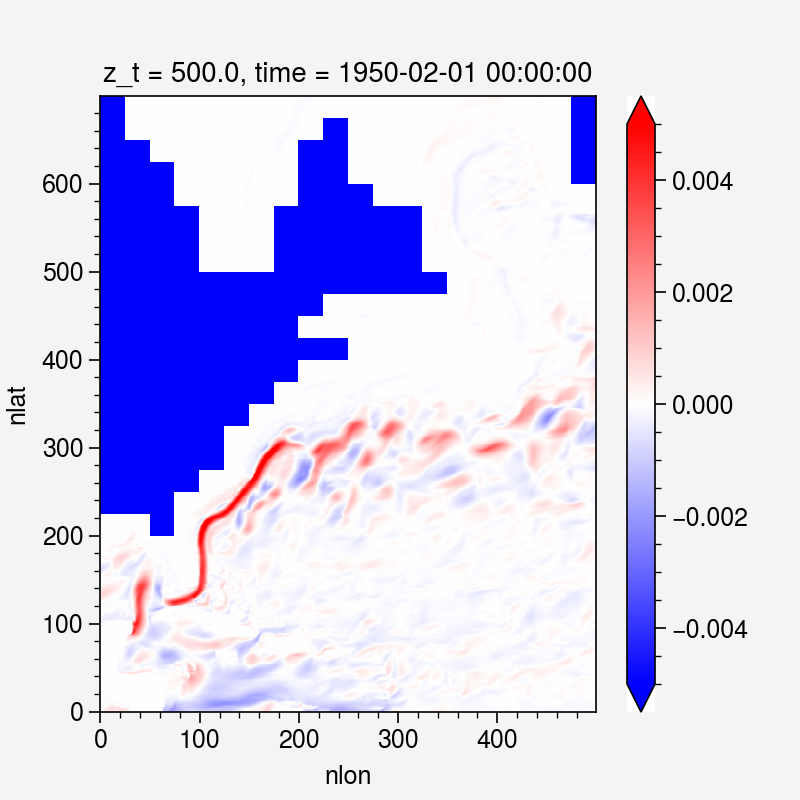

In [16]:
(ds_vnt_r_TH.VNT + ds_uet_r_TH.UET).isel(time=0,z_t=0).plot(vmin=-0.005,vmax=0.005,cmap='bwr')

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200, 700 
nlat1_r_t12, nlat2_r_t12 = 1300, 2000

nlon1_r_g16, nlon2_r_g16 = 260, 321
nlat1_r_g16, nlat2_r_g16 = 230, 350

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

# box1 (bx1), southeast US coast box
lon1_bx1, lon2_bx1 = -82, -79
lat1_bx1, lat2_bx1 = 30, 33
# box2 (bx2), northeast US coast box
lon1_bx2, lon2_bx2 = -71, -68
lat1_bx2, lat2_bx2 = 40.5, 43.5
# ===========================================================

z = 15*100 # 15 m 
# z = 2000*100 # 2000 m 

time2 = np.arange(2001,2100+1,1)

chunks_HR = {'nlat':400,'nlon':300,'z_t':1}
chunks_LR = {'nlat':384,'nlon':320/5,'z_t':1}

# --- 30N ---
# lat1_sec1 = 30
# lon1_sec1, lon2_sec1 = -82+360, -74+360

# ilat1_t12 = 1497
# ilon1_t12, ilon2_t12 = 270, 360

# ilat1_g16 = 279
# ilon1_g16, ilon2_g16 = 279, 292
# -----------

# --- 26.5 N ---
# lat1_sec1 = 26.5
# lon1_sec1, lon2_sec1 = -82+360, -74+360

# ilat1_t12 = 1456
# ilon1_t12, ilon2_t12 = 270, 360

# ilat1_g16 = 270
# ilon1_g16, ilon2_g16 = 279, 292
# --------------

# --- 28 N ---
lat1_sec1 = 28
lon1_sec1, lon2_sec1 = -82+360, -74+360 # pop tools xoak uses TLONG (0-360) for the closest points

ilat1_t12 = 1473
ilon1_t12, ilon2_t12 = 280, 360

ilat1_g16 = 274
ilon1_g16, ilon2_g16 = 281, 290
# --------------

# # --- 35N ---
# lat1_sec1 = 35
# lon1_sec1, lon2_sec1 = -76+360, -68+360 # TLONG is 0-360

# ilat1_t12 = 1558 #1562
# ilon1_t12, ilon2_t12 = 320, 420

# ilat1_g16 = 290-1
# ilon1_g16, ilon2_g16 = 287-2, 295
# # ------------

outdir = '/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/pics/'
pic1 = outdir + 'SfcVelTrendFutureMinusHistUSEastCoastCESM4reviewer3_2021Dec24.png'

# read data files

In [4]:
# read TH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_TH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway
    history:       Thu Aug 26 14:23:01 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-03-16 at 08:33:13.4
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  34411091
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [5]:
# read CH U, V vel

# 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_CH = np.arange(401,500+1) 
prefix1a_CH = 'B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.'

indir1a_uvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/UVEL/')
infiles1a_uvel_CH = [indir1a_uvel_CH + prefix1a_CH + 'UVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
                     for iyr in yrs1a_CH]
infiles1a_uvel_CH

indir1a_vvel_CH = ('/ihesp/archive/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02/ocn/proc/VVEL/')
infiles1a_vvel_CH = [indir1a_vvel_CH + prefix1a_CH + 'VVEL.' + str(iyr).zfill(4) +'01-' + str(iyr).zfill(4)+ '12.nc'
               for iyr in yrs1a_CH]
infiles1a_vvel_CH

ds_uvel_CH = xr.open_mfdataset(infiles1a_uvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)

ds_vvel_CH = xr.open_mfdataset(infiles1a_vvel_CH, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_HR, 
                       parallel=True)
ds_vvel_CH 

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 1200, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
    ULONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ULAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
  * time                (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:0...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/51)
    dz                  (z_t) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(400, 300), meta=np.ndarray>
    ...                  ...
    salinity_factor     float64 ...
    sflux_factor        float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    time_bound          (time, d2) object dask.array<chunksize=(12, 2), meta=np.ndarray>
    VVEL                (time, z_t, nlat, nlon) float32 dask.array<chunksize=(12, 1, 400, 300), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02
    history:       Sat Jul 24 15:04:58 2021: ncap2 -A -s time=udunits(time, "...
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-01-03 at 01:54:07.7
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  86568131
    tavg_sum:      2678400.0
    NCO:           netCDF Operators version 4.8.1 (Homepage = http://nco.sf.n...

In [6]:
# infile1_uvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
#                    'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.UVEL.185001-200512.nc')
# infile1_vvel_TL = ('/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
#                    'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.VVEL.185001-200512.nc')

# infile2_uvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
#                    'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-210512.nc')
# infile2_vvel_TL = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/tseries/ocn/to_archive/'
#                    'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-210512.nc')

# ds_uvel_TL = xr.open_mfdataset([infile1_uvel_TL, infile2_uvel_TL], compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)

# ds_vvel_TL = xr.open_mfdataset([infile1_vvel_TL, infile2_vvel_TL], compat="override", combine="by_coords", 
#                        data_vars="minimal", coords="minimal", chunks=chunks_LR, parallel=True)
# ds_vvel_TL

In [7]:
# read TL U, V vel
indir1_TL = ('/ihesp/archive/'
          'B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/')
infiles1_TL = sorted(glob.glob(indir1_TL+'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.200[1-5]-??.nc'))

indir2_TL = ('/ihesp/archive/'
          'B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/')
infiles2a_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.20??-??.nc'))

infiles2b_TL = sorted(glob.glob(indir2_TL+'cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2100-??.nc')) # add year 2100, 
infiles_TL = infiles1_TL + infiles2a_TL + infiles2b_TL
print(infiles_TL[0])
print(infiles_TL[-1])

ds0_TL=xr.open_dataset(infiles2a_TL[0])

keeplist=['UVEL','VVEL','time','z_t','ULONG','ULAT']

droplist_TL=list(ds0_TL.variables)
for i in keeplist:
    droplist_TL.remove(i)
# droplist
droplist_TL = droplist_TL + ['CFC_IFRAC','CFC_XKW','CFC_ATM_PRESS','CFC11','STF_CFC11','CFC12','STF_CFC12']
# HIST and RCP85 have different outputs, add more variables to droplist
# print(droplist_TL)

ds_TL = xr.open_mfdataset(infiles_TL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_TL, parallel=True)
ds_TL

/ihesp/archive/B.E.13.BHISTC5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.2001-01.nc
/ihesp/archive/B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF/ocn/monthly/cmpr_B.E.13.BRCP85C5CN.ne30g16.sehires38.003.sunway.CN_OFF.pop.h.2100-12.nc


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1199, z_t: 60)
Coordinates:
  * time     (time) object 2001-02-01 00:00:00 ... 2101-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
    VVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
Attributes:
    title:         B.E.13.BHISTC5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-29 at 09:51:46.0
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  1378625
    tavg_sum:      2678400.0

In [8]:
# read CL U, V  vel
indir_CL = ('/ihesp/archive/'
          'B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/')
infiles1a_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.04??-??.nc'))
del infiles1a_CL[0:11+1] # remove year 400

infiles1b_CL = sorted(glob.glob(indir_CL+'cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0500-??.nc')) # add year 500, 
infiles_CL = infiles1a_CL + infiles1b_CL
print(infiles_CL[0])
print(infiles_CL[-1])

ds0_CL=xr.open_dataset(infiles_CL[0])

keeplist=['UVEL','VVEL','time','z_t','ULONG','ULAT']

droplist_CL=list(ds0_CL.variables)
for i in keeplist:
    droplist_CL.remove(i)
# droplist

ds_CL = xr.open_mfdataset(infiles_CL, compat="override", combine="by_coords", 
                       data_vars="minimal", coords="minimal", chunks=chunks_LR, 
                       drop_variables=droplist_CL, parallel=True)
ds_CL

/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0401-01.nc
/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/ocn/monthly/cmpr_B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.0500-12.nc


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1197, z_t: 60)
Coordinates:
  * time     (time) object 0401-02-01 00:00:00 ... 0501-01-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 64), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    UVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
    VVEL     (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 384, 64), meta=np.ndarray>
Attributes:
    title:         B.E.13.B1850C5.ne30g16.sehires38.003.sunway
    history:       none
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    contents:      Diagnostic and Prognostic Variables
    source:        CCSM POP2, the CCSM Ocean Component
    revision:      $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy@ucar.edu $
    calendar:      All years have exactly  365 days.
    start_time:    This dataset was created on 2020-04-28 at 19:05:54.5
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    nsteps_total:  3650750
    tavg_sum:      2678400.0

In [9]:
# infile_uvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
#                   'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.UVEL.25001-50112.nc')
# infile_vvel_CL = ('/ihesp/archive/B.E.13.B1850C5.ne30g16.sehires38.003.sunway/tseries/ocn/to_archive/'
#                   'B.E.13.B1850C5.ne30g16.sehires38.003.sunway.pop.h.VVEL.25001-50112.nc')

# ds_uvel_CL = xr.open_dataset(infile_uvel_CL, chunks=chunks_LR)
# ds_vvel_CL = xr.open_dataset(infile_vvel_CL, chunks=chunks_LR)
# ds_vvel_CL

In [10]:
# supplimentary files 
# infile0_LR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'cmpr_B.E.13.BHISTC5.ne30g16.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_LR = xr.open_dataset(infile0_LR)
# ds0_LR

# infile0_HR = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/'
#               'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.1850-01.nc')
# ds0_HR = xr.open_dataset(infile0_HR)
# ds0_HR

infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
ds_t12 = xr.open_dataset(infile_t12)
ds_t12

infile_g16 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
              'POPgrids_gx1v6_2020Jun29.nc') # POP g16 grid file
ds_g16 = xr.open_dataset(infile_g16)
ds_g16

ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                       nlat=slice(nlat1_r_t12, nlat2_r_t12))
ds_r_g16 = ds_g16.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                       nlat=slice(nlat1_r_g16, nlat2_r_g16))

# data analysis 

In [11]:
%%time
time_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') 
u_r_z_TH = ds_uvel_TH.UVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
u_r_z_rs_TH = u_r_z_TH.assign_coords(time=time_s_TH).resample(time='A').mean('time').compute()

v_r_z_TH = ds_vvel_TH.VVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
v_r_z_rs_TH = v_r_z_TH.assign_coords(time=time_s_TH).resample(time='A').mean('time').compute()
v_r_z_rs_TH

CPU times: user 3.26 s, sys: 329 ms, total: 3.59 s
Wall time: 1min 30s


<xarray.DataArray 'VVEL' (time: 100, nlat: 700, nlon: 500)>
array([[[ 5.0404253 ,  3.8274708 ,  2.2243226 , ...,  3.6525185 ,
          3.5658188 ,  3.4656389 ],
        [ 4.724835  ,  3.5263832 ,  1.9117179 , ...,  3.5084445 ,
          3.433532  ,  3.3443096 ],
        [ 4.215998  ,  3.0852072 ,  1.599857  , ...,  3.3339443 ,
          3.2905319 ,  3.224307  ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 1.0973922 ,  0.921818  ,  0.8545823 , ...,  2.5264883 ,
          2.2887783 ,  2.107879  ],
        [ 0.6629973 ,  0.409935  ,  0.2245946 , ...,  2.5333238 ,
          2.3306935 ,  2.1860652 ],
        [ 0.14940389, -0.1828429 , -0.5317897 , ...,  2.5718567 ,
          2.419237  ,  2.3185418 ],
...
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 7.98718   ,  6.862327  ,  5.770471  , ...,  3.8471396 ,
          4.0575514 ,  4.2619805 ],
        [ 7.957186  ,  6.845402  ,  5.730887  , ...,  3.7969263 ,
          4.0286565 ,  4.2430873 ],
        [ 7.6664124 ,  6.6110616 ,  5.5376306 , ...,  3.7216015 ,
          3.946635  ,  4.1496615 ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]], dtype=float32)
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 -89.9 -89.8 -89.7 -89.6 ... -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 11.82 11.82 11.82 11.82 ... -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 270.1 270.1 270.2 270.4 ... -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 11.77 11.77 11.77 11.77 ... -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In [12]:
%%time
time_s_CH = ds_uvel_CH.time.to_pandas().index.shift(-1,'D') 
u_r_z_CH = ds_uvel_CH.UVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
u_r_z_rs_CH = u_r_z_CH.assign_coords(time=time_s_CH).resample(time='A').mean('time').compute()
v_r_z_CH = ds_vvel_CH.VVEL.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
                                nlat=slice(nlat1_r_t12, nlat2_r_t12)).sel(z_t=z, method='nearest')
v_r_z_rs_CH = v_r_z_CH.assign_coords(time=time_s_CH).resample(time='A').mean('time').compute()
v_r_z_rs_CH

CPU times: user 3.14 s, sys: 355 ms, total: 3.5 s
Wall time: 1min 30s


<xarray.DataArray 'VVEL' (time: 100, nlat: 700, nlon: 500)>
array([[[ 8.204425  ,  8.391732  ,  8.374383  , ...,  3.0405076 ,
          3.2101376 ,  3.4029882 ],
        [ 7.91643   ,  8.051533  ,  7.9693074 , ...,  2.9229946 ,
          3.1974661 ,  3.4536197 ],
        [ 7.3743215 ,  7.5031238 ,  7.4017425 , ...,  2.7509701 ,
          3.0996416 ,  3.4542263 ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[-5.1573043 , -6.585226  , -7.887055  , ...,  5.5431046 ,
          5.543923  ,  5.4019394 ],
        [-5.6395698 , -7.1076207 , -8.413292  , ...,  5.508385  ,
          5.5679364 ,  5.4735446 ],
        [-6.091142  , -7.5791802 , -8.886073  , ...,  5.3734684 ,
          5.4639745 ,  5.4352207 ],
...
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 5.772306  ,  5.055331  ,  4.5958614 , ...,  3.5592155 ,
          3.1866481 ,  2.906909  ],
        [ 5.1858745 ,  4.5523925 ,  4.0314994 , ...,  3.4291418 ,
          3.0870068 ,  2.8219175 ],
        [ 4.4025083 ,  3.8749046 ,  3.3279607 , ...,  3.1920338 ,
          2.8761318 ,  2.642357  ],
        ...,
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [-1.        , -1.        , -1.        , ..., -1.        ,
         -1.        , -1.        ]]], dtype=float32)
Coordinates:
  * time     (time) object 0401-12-31 00:00:00 ... 0500-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 -89.9 -89.8 -89.7 -89.6 ... -1.0 -1.0 -1.0
    ULAT     (nlat, nlon) float64 11.82 11.82 11.82 11.82 ... -1.0 -1.0 -1.0
    TLONG    (nlat, nlon) float64 270.1 270.1 270.2 270.4 ... -1.0 -1.0 -1.0
    TLAT     (nlat, nlon) float64 11.77 11.77 11.77 11.77 ... -1.0 -1.0 -1.0
Dimensions without coordinates: nlat, nlon

In [13]:
%%time
time_s_TL = ds_TL.time.to_pandas().index.shift(-1,'D') 
u_r_z_TL = ds_TL.UVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
u_r_z_rs_TL = u_r_z_TL.assign_coords(time=time_s_TL).resample(time='A').mean('time').compute()

v_r_z_TL = ds_TL.VVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
v_r_z_rs_TL = v_r_z_TL.assign_coords(time=time_s_TL).resample(time='A').mean('time').compute()
v_r_z_rs_TL

CPU times: user 3.55 s, sys: 140 ms, total: 3.69 s
Wall time: 4min


<xarray.DataArray 'VVEL' (time: 100, nlat: 120, nlon: 60)>
array([[[  1.8789445 ,   1.6319137 ,   1.4175316 , ...,   4.516933  ,
           4.286947  ,   4.122481  ],
        [  1.816915  ,   1.4614973 ,   1.12332   , ...,   4.5158362 ,
           4.2905755 ,   4.1364093 ],
        [  1.7477528 ,   1.2609795 ,   0.8390446 , ...,   4.5057044 ,
           4.2959867 ,   4.1512127 ],
        ...,
        [         nan,          nan,          nan, ...,  -8.09797   ,
           0.29670182,   0.6242373 ],
        [         nan,          nan,          nan, ..., -11.614616  ,
          -1.0347701 ,  -1.0689404 ],
        [         nan,          nan,          nan, ..., -14.7480955 ,
          -2.8751829 ,  -3.0475693 ]],

       [[  1.6798183 ,   1.4112436 ,   1.4275737 , ...,   4.049048  ,
           3.986411  ,   3.9979115 ],
        [  1.5203328 ,   1.2188505 ,   1.1653414 , ...,   4.08167   ,
           4.015213  ,   4.032957  ],
        [  1.3699726 ,   1.0234958 ,   0.91582346, ...,   4.104703  ,
           4.0335846 ,   4.058085  ],
...
        [         nan,          nan,          nan, ...,  -5.3291225 ,
          -3.351354  ,  -2.2012184 ],
        [         nan,          nan,          nan, ...,  -8.4595785 ,
          -4.684361  ,  -3.2035801 ],
        [         nan,          nan,          nan, ..., -12.498901  ,
          -6.9928737 ,  -4.4720454 ]],

       [[  3.7130668 ,   3.4790418 ,   3.434438  , ...,   4.896376  ,
           4.7805014 ,   4.6688046 ],
        [  3.575476  ,   3.2865322 ,   3.1425226 , ...,   4.851948  ,
           4.721553  ,   4.594223  ],
        [  3.412883  ,   3.0507505 ,   2.7877808 , ...,   4.787951  ,
           4.6478367 ,   4.515593  ],
        ...,
        [         nan,          nan,          nan, ...,  -5.372392  ,
          -3.019337  ,  -2.0006943 ],
        [         nan,          nan,          nan, ...,  -8.595473  ,
          -4.4721475 ,  -2.9360878 ],
        [         nan,          nan,          nan, ..., -12.560123  ,
          -6.792004  ,  -4.159743  ]]], dtype=float32)
Coordinates:
  * time     (time) object 2001-12-31 00:00:00 ... 2100-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 253.6 254.8 255.9 257.0 ... 318.1 319.0 320.0
    ULAT     (nlat, nlon) float64 11.69 11.68 11.68 11.67 ... 58.74 58.73 58.73
Dimensions without coordinates: nlat, nlon

In [14]:
%%time
time_s_CL = ds_CL.time.to_pandas().index.shift(-1,'D') 
u_r_z_CL = ds_CL.UVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
u_r_z_rs_CL = u_r_z_CL.assign_coords(time=time_s_CL).resample(time='A').mean('time').compute()

v_r_z_CL = ds_CL.VVEL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), 
                           nlat=slice(nlat1_r_g16, nlat2_r_g16)).sel(z_t=z, method='nearest')
v_r_z_rs_CL = v_r_z_CL.assign_coords(time=time_s_CL).resample(time='A').mean('time').compute()
v_r_z_rs_CL

CPU times: user 6.13 s, sys: 251 ms, total: 6.38 s
Wall time: 3min 57s


<xarray.DataArray 'VVEL' (time: 100, nlat: 120, nlon: 60)>
array([[[  1.9621371 ,   1.6616858 ,   1.3214498 , ...,   4.0265093 ,
           3.938411  ,   3.7910697 ],
        [  1.9296228 ,   1.4933704 ,   1.0493274 , ...,   4.1217465 ,
           4.006231  ,   3.8592856 ],
        [  1.8774743 ,   1.3119651 ,   0.76983714, ...,   4.205486  ,
           4.0692177 ,   3.907554  ],
        ...,
        [         nan,          nan,          nan, ...,  -8.171173  ,
           0.77807903,   1.7277732 ],
        [         nan,          nan,          nan, ..., -11.152381  ,
          -1.8962151 ,   0.2885819 ],
        [         nan,          nan,          nan, ..., -13.382592  ,
          -4.086659  ,  -3.2484803 ]],

       [[  1.1932281 ,   0.9831694 ,   1.0964717 , ...,   4.11873   ,
           3.9263086 ,   3.7723293 ],
        [  1.3060997 ,   0.968908  ,   0.92058414, ...,   4.2218013 ,
           3.9911282 ,   3.858403  ],
        [  1.4225578 ,   0.9354264 ,   0.73292047, ...,   4.307461  ,
           4.0628705 ,   3.9402828 ],
...
        [         nan,          nan,          nan, ...,  -7.2667727 ,
           1.6655884 ,   2.099469  ],
        [         nan,          nan,          nan, ..., -10.655069  ,
          -0.1461647 ,   0.58344513],
        [         nan,          nan,          nan, ..., -13.51518   ,
          -2.2584355 ,  -2.0321727 ]],

       [[  1.3826574 ,   1.4310268 ,   1.3537849 , ...,   4.171957  ,
           3.93015   ,   3.7083902 ],
        [  1.4766302 ,   1.4881406 ,   1.2849191 , ...,   4.25499   ,
           3.9797857 ,   3.757869  ],
        [  1.5604984 ,   1.5308442 ,   1.2576941 , ...,   4.2899966 ,
           4.0084653 ,   3.8024235 ],
        ...,
        [         nan,          nan,          nan, ...,  -8.137235  ,
           0.54196304,   0.8393717 ],
        [         nan,          nan,          nan, ..., -11.587596  ,
          -1.4898661 ,  -0.5029969 ],
        [         nan,          nan,          nan, ..., -14.383248  ,
          -3.9136646 ,  -3.1245995 ]]], dtype=float32)
Coordinates:
  * time     (time) object 0401-12-31 00:00:00 ... 0500-12-31 00:00:00
    z_t      float32 1.5e+03
    ULONG    (nlat, nlon) float64 253.6 254.8 255.9 257.0 ... 318.1 319.0 320.0
    ULAT     (nlat, nlon) float64 11.69 11.68 11.68 11.67 ... 58.74 58.73 58.73
Dimensions without coordinates: nlat, nlon

In [15]:
spd_r_z_TH = xr.ufuncs.sqrt(u_r_z_rs_TH**2+ v_r_z_rs_TH**2)
spd_r_z_CH = xr.ufuncs.sqrt(u_r_z_rs_CH**2+ v_r_z_rs_CH**2).assign_coords(time=spd_r_z_TH.time)
spd_r_z_THmCH = spd_r_z_TH - spd_r_z_CH
spd_r_z_THmCH
spd_r_z_TL = xr.ufuncs.sqrt(u_r_z_rs_TL**2+ v_r_z_rs_TL**2)
spd_r_z_CL = xr.ufuncs.sqrt(u_r_z_rs_CL**2+ v_r_z_rs_CL**2).assign_coords(time=spd_r_z_TL.time)
spd_r_z_TLmCL = spd_r_z_TL - spd_r_z_CL

In [16]:
%%time 
# takes ~5 min to run
_, nlat_r_t12, nlon_r_t12 = spd_r_z_THmCH.shape
spd_tr_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
spd_tr_r_THmCH[:] = np.nan
p_r_THmCH = np.empty((nlat_r_t12, nlon_r_t12))
p_r_THmCH[:] = np.nan

for ilon in np.arange(0,nlon_r_t12):
    for ilat in np.arange(0,nlat_r_t12):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd_tr_r_THmCH[ilat,ilon], _, _, p_r_THmCH[ilat,ilon], _ = stats.linregress(
            time2, spd_r_z_THmCH[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_r_t12 = ds_r_t12.ULAT#.where(px_NA_TLmCL>0.05)
latm_r_t12 = np.where(p_r_THmCH>0.1,lat_r_t12, np.nan) # m: mask

lon_r_t12 = ds_r_t12.ULONG#.where(px_NA_TLmCL>0.05)
lonm_r_t12 = np.where(p_r_THmCH>0.1,lon_r_t12, np.nan) # m: mask

CPU times: user 4min 20s, sys: 1.17 s, total: 4min 21s
Wall time: 4min 20s


In [17]:
%%time
_, nlat_r_g16, nlon_r_g16 = spd_r_z_TLmCL.shape

spd_tr_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
spd_tr_r_TLmCL[:] = np.nan
p_r_TLmCL = np.empty((nlat_r_g16, nlon_r_g16))
p_r_TLmCL[:] = np.nan

for ilon in np.arange(0,nlon_r_g16):
    for ilat in np.arange(0,nlat_r_g16):
#         slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        spd_tr_r_TLmCL[ilat,ilon], _, _, p_r_TLmCL[ilat,ilon], _ = stats.linregress(
            time2, spd_r_z_TLmCL[:,ilat,ilon])
    
# px_NA_TLmCL = xr.DataArray(data=p_NA_TLmCL, dims=["nlon","nlat"])  
# px_NA_TLmCL

lat_r_g16 = ds_r_g16.ULAT#.where(px_NA_TLmCL>0.05)
latm_r_g16 = np.where(p_r_TLmCL>0.1,lat_r_g16, np.nan) # m: mask

lon_r_g16 = ds_r_g16.ULONG#.where(px_NA_TLmCL>0.05)
lonm_r_g16 = np.where(p_r_TLmCL>0.1,lon_r_g16, np.nan) # m: mask

CPU times: user 5.96 s, sys: 21.7 ms, total: 5.98 s
Wall time: 5.98 s


TH spd begin/end time 2001-12-31 00:00:00 2100-12-31 00:00:00
CH spd begin/end time 2001-12-31 00:00:00 2100-12-31 00:00:00
TL spd begin/end time 2001-12-31 00:00:00 2100-12-31 00:00:00
CL spd begin/end time 2001-12-31 00:00:00 2100-12-31 00:00:00


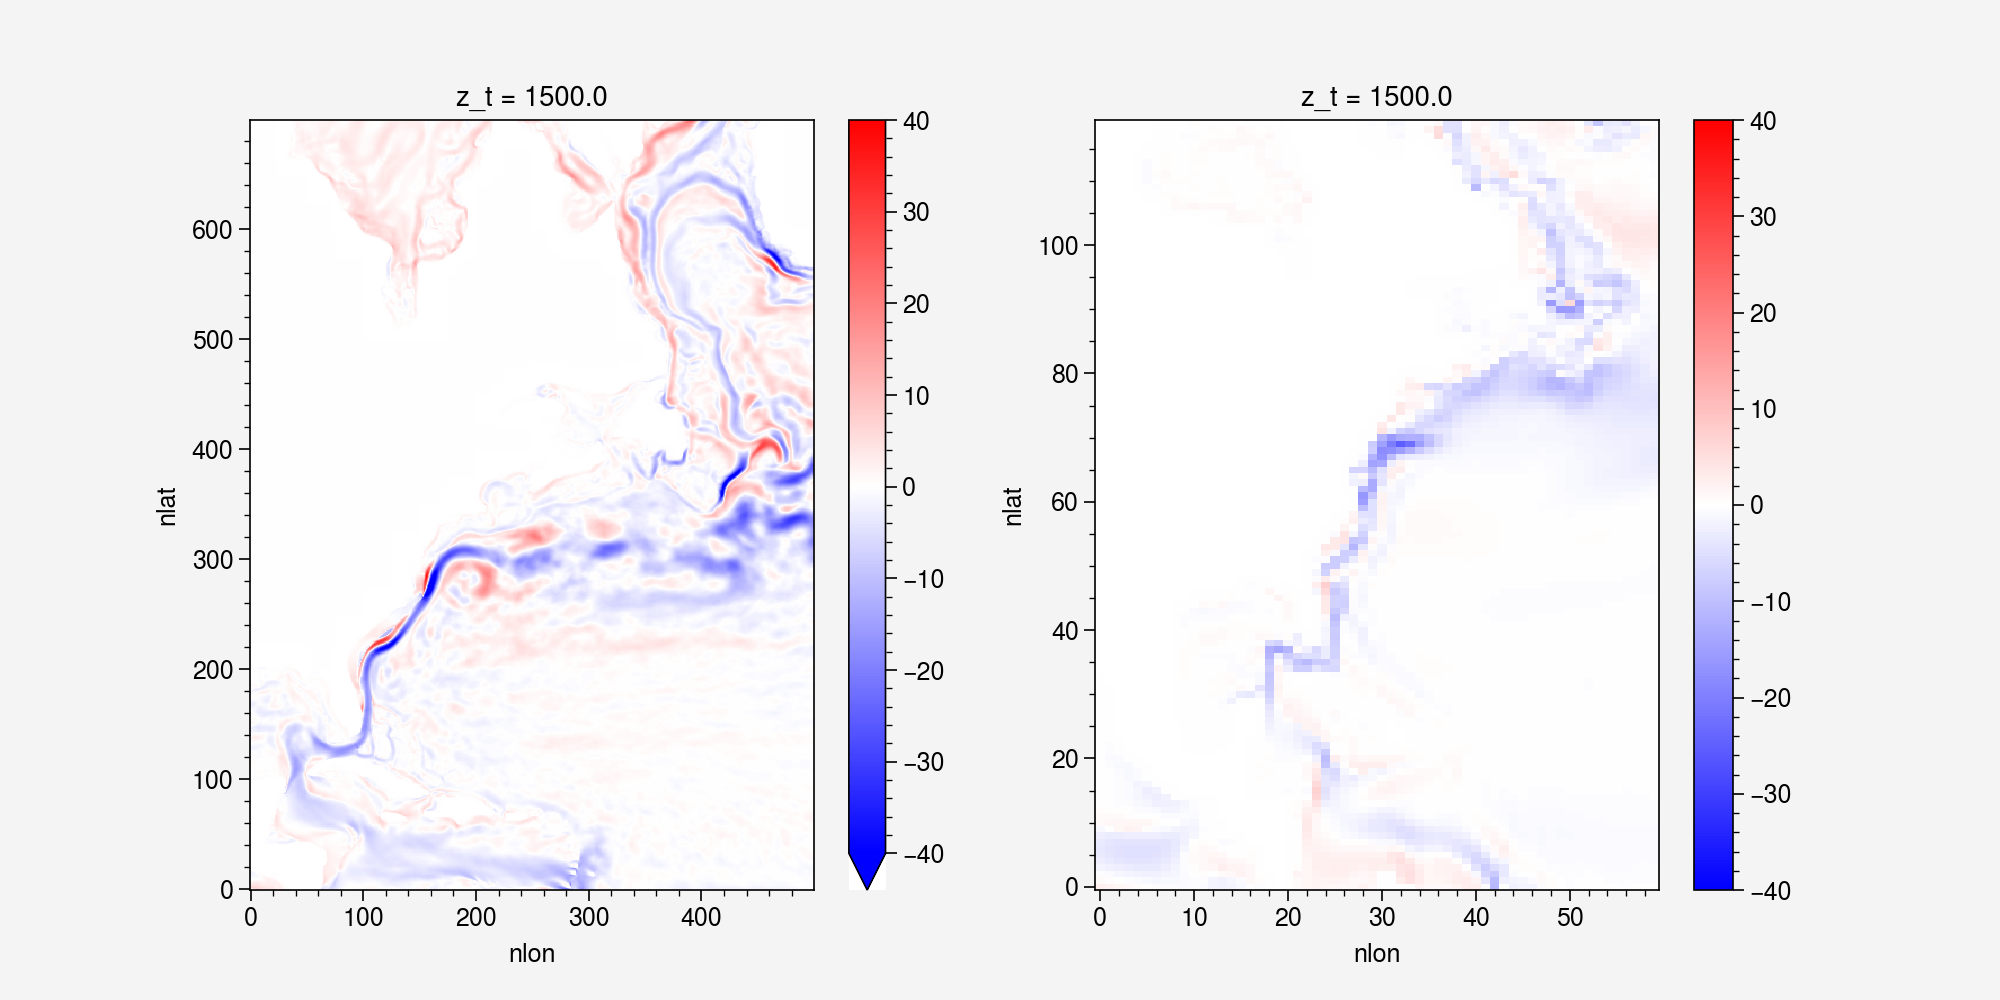

In [18]:
# compute vel spd difference between two time periods
print('TH spd begin/end time', spd_r_z_TH.time.values[0], spd_r_z_TH.time.values[-1])
print('CH spd begin/end time', spd_r_z_CH.time.values[0], spd_r_z_CH.time.values[-1])

print('TL spd begin/end time', spd_r_z_TL.time.values[0], spd_r_z_TL.time.values[-1])
print('CL spd begin/end time', spd_r_z_CL.time.values[0], spd_r_z_CL.time.values[-1])

dspd_r_z_TH=spd_r_z_TH.sel(time=slice('2081','2100')).mean('time')-spd_r_z_TH.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_CH=spd_r_z_CH.sel(time=slice('2081','2100')).mean('time')-spd_r_z_CH.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_THmCH = dspd_r_z_TH - dspd_r_z_CH

dspd_r_z_TL=spd_r_z_TL.sel(time=slice('2081','2100')).mean('time')-spd_r_z_TL.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_CL=spd_r_z_CL.sel(time=slice('2081','2100')).mean('time')-spd_r_z_CL.sel(time=slice('2001','2020')).mean('time')
dspd_r_z_TLmCL = dspd_r_z_TL - dspd_r_z_CL

fig, axs = plt.subplots(1,2,figsize=(10,5))
dspd_r_z_THmCH.plot(ax=axs[0],vmin=-40,vmax=40,cmap='bwr')
dspd_r_z_TLmCL.plot(ax=axs[1],vmin=-40,vmax=40,cmap='bwr')

# make pics

28.01783262314108
28.284060737650435


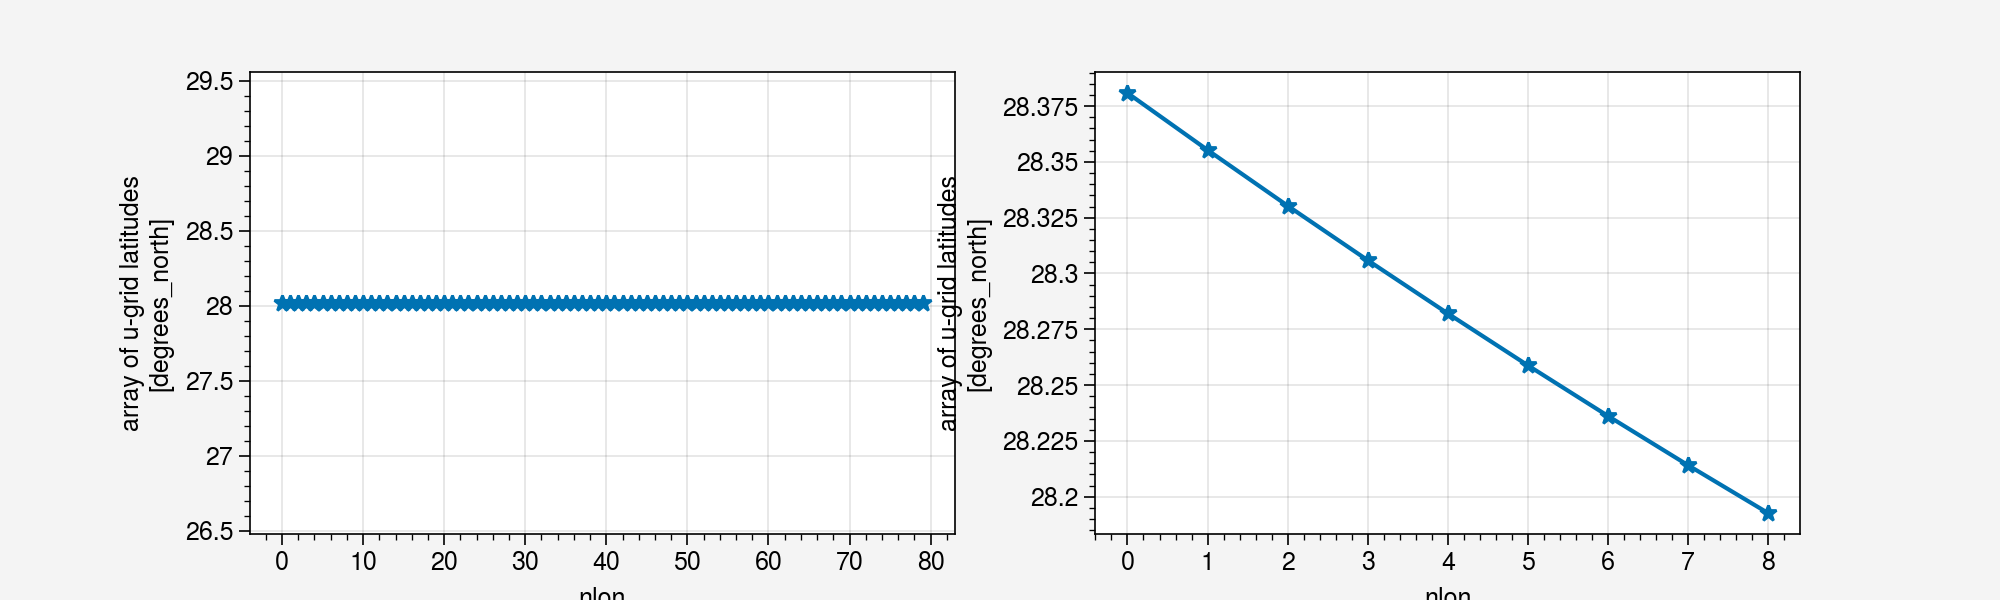

In [19]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
ds_vvel_TH.ULAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).plot(ax=axs[0], marker='*')
print(ds_vvel_TH.ULAT.isel(nlat=ilat1_t12,nlon=slice(ilon1_t12,ilon2_t12)).mean().values)

ds0_TL.ULAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).plot(ax=axs[1], marker='*')
print(ds0_TL.ULAT.isel(nlat=ilat1_g16,nlon=slice(ilon1_g16,ilon2_g16)).mean().values)

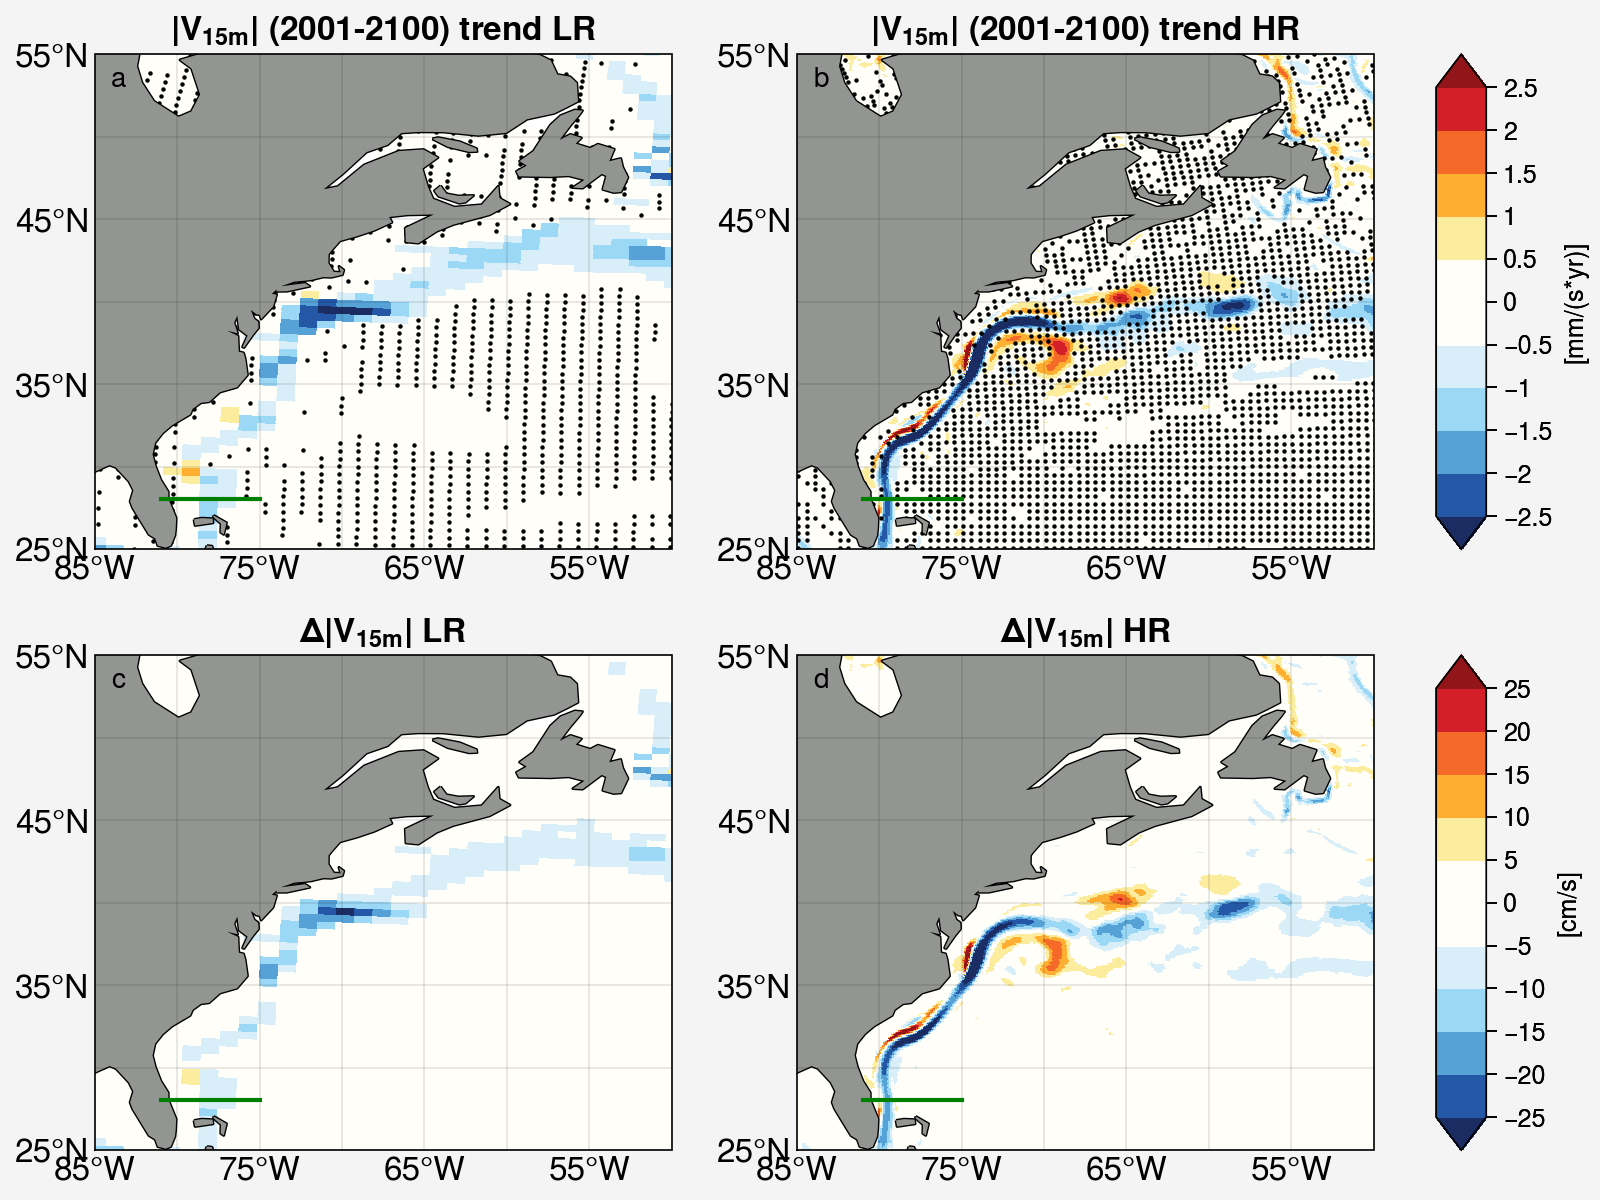

In [20]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

cut=-0.1

m00=axs[0,0].pcolormesh(ds_r_g16.ULONG, ds_r_g16.ULAT, 
        spd_tr_r_TLmCL*10, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,0].scatter(lonm_r_g16[::1,::1],latm_r_g16[::1,::1],transform=pc, marker='o',s=1,c='k')
axs[0,0].plot([-81,-75],[28,28],transform=pc,c='g')
axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,0].format(land=True, landcolor='grey')
axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,0].xaxis.set_major_formatter(lon_formatter)
axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,0].yaxis.set_major_formatter(lat_formatter)
axs[0,0].set_title(r'$|V_{15m}|$ (2001-2100) trend LR', fontsize=12, fontweight='bold')
axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=10)
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm/s]',width='2em',shrink=1)

m01=axs[0,1].pcolormesh(ds_r_t12.ULONG, ds_r_t12.ULAT, 
        spd_tr_r_THmCH*10, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[0,1].scatter(lonm_r_t12[::5,::5],latm_r_t12[::5,::5],transform=pc, marker='o',s=1,c='k')
axs[0,1].plot([-81,-75],[28,28],transform=pc,c='g')
axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[0,1].format(land=True, landcolor='grey')
axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[0,1].xaxis.set_major_formatter(lon_formatter)
axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[0,1].yaxis.set_major_formatter(lat_formatter)
axs[0,1].set_title(r'$|V_{15m}|$ (2001-2100) trend HR', fontsize=12, fontweight='bold')
axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=10)
cb = axs[0,1].colorbar(m01,loc='r',label='[mm/(s*yr)]',width='2em',shrink=1)

m10=axs[1,0].pcolormesh(ds_r_g16.ULONG, ds_r_g16.ULAT, 
        dspd_r_z_TLmCL, levels=np.arange(-25, 25+0.1, 5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,0].scatter(lonm_r_g16[::1,::1],latm_r_g16[::1,::1],transform=pc, marker='o',s=1,c='k')
axs[1,0].plot([-81,-75],[28,28],transform=pc, c='g')
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
# axs[1,0].set_title(r'$|V_{15m}|$ (2001-2100) trend LR', fontsize=12, fontweight='bold')
axs[1,0].set_title(r'$\Delta|V_{15m}|$ LR', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=10)
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm/s]',width='2em',shrink=1)

m11=axs[1,1].pcolormesh(ds_r_t12.ULONG, ds_r_t12.ULAT, 
        dspd_r_z_THmCH, levels=np.arange(-25, 25+0.1, 5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
# axs[1,1].scatter(lonm_r_t12[::5,::5],latm_r_t12[::5,::5],transform=pc, marker='o',s=1,c='k')
axs[1,1].plot([-81,-75],[28,28],transform=pc,c='g')
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
# axs[1,1].set_title(r'$|V_{15m}|$ (2001-2100) trend HR', fontsize=12, fontweight='bold')
axs[1,1].set_title(r'$\Delta|V_{15m}|$ HR', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=10)
cb = axs[1,1].colorbar(m11,loc='r',label='[cm/s]',width='2em',shrink=1)

fig1.savefig(pic1, bbox_inches='tight')

# Appendix

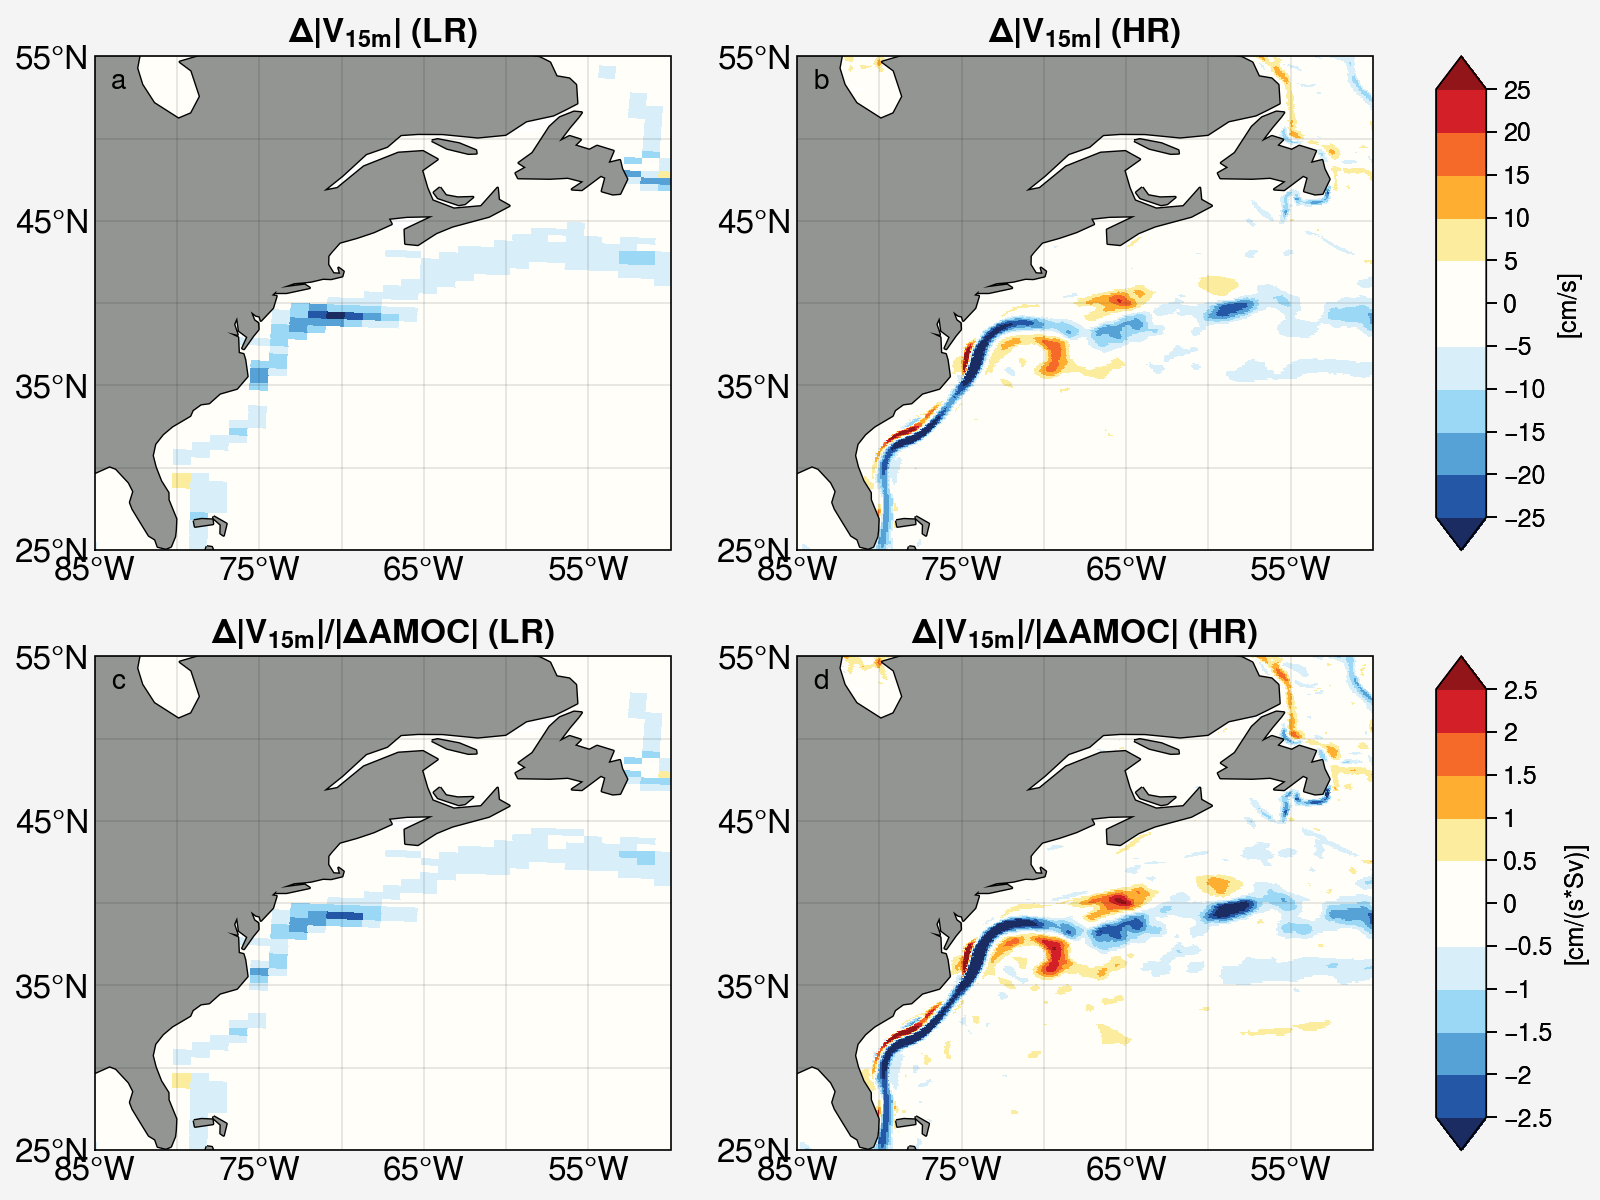

In [9]:
pc = cartopy.crs.PlateCarree()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

fig1, axs = plot.subplots(nrows=2,ncols=2,proj='cyl',width='8in',height='6in')

cut=-0.1

# m00=axs[0,0].pcolormesh(ds_r_g16.TLONG, ds_r_g16.TLAT, 
#         dspd_r_TLmCL, levels=np.arange(-25,25+1,5), transform=pc, 
#         cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# # axs[0,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,0].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,0].format(land=True, landcolor='grey')
# axs[0,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,0].xaxis.set_major_formatter(lon_formatter)
# axs[0,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,0].yaxis.set_major_formatter(lat_formatter)
# axs[0,0].set_title(r'$\Delta|V_{15m}|$ (LR)', fontsize=12, fontweight='bold')
# axs[0,0].text(-84, 53, 'a', transform=pc, fontsize=10)

# m01=axs[0,1].pcolormesh(ds_r_t12.TLONG, ds_r_t12.TLAT, 
#         dspd_r_THmCH, levels=np.arange(-25,25+1,5), transform=pc, 
#         cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# # axs[0,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# # Boston (71.1W, 42.4N)
# axs[0,1].coastlines(resolution='110m', color='black', linewidth=1)
# axs[0,1].format(land=True, landcolor='grey')
# axs[0,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
# axs[0,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
# axs[0,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
# axs[0,1].xaxis.set_major_formatter(lon_formatter)
# axs[0,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
# axs[0,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
# axs[0,1].yaxis.set_major_formatter(lat_formatter)
# axs[0,1].set_title(r'$\Delta|V_{15m}|$ (HR)', fontsize=12, fontweight='bold')
# axs[0,1].text(-84, 53, 'b', transform=pc, fontsize=10)
# cb = axs[0,1].colorbar(m01,loc='r',label='[cm/s]',width='2em',shrink=1)

m10=axs[1,0].pcolormesh(ds_r_g16.TLONG, ds_r_g16.TLAT, 
        spd2AMOC_r_TLmCL, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,0].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,0].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,0].format(land=True, landcolor='grey')
axs[1,0].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,0].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,0].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,0].xaxis.set_major_formatter(lon_formatter)
axs[1,0].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,0].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,0].yaxis.set_major_formatter(lat_formatter)
axs[1,0].set_title(r'$\Delta|V_{15m}|/ |\Delta AMOC|$ (LR)', fontsize=12, fontweight='bold')
axs[1,0].text(-84, 53, 'c', transform=pc, fontsize=10)
# cb = axs[1,0].colorbar(m10,loc='r',label='[cm/s]',width='2em',shrink=1)

m11=axs[1,1].pcolormesh(ds_r_t12.TLONG, ds_r_t12.TLAT, 
        spd2AMOC_r_THmCH, levels=np.arange(-2.5,2.5+0.1,0.5), transform=pc, 
        cmap="ColdHot", cmap_kw={'cut': cut}, extend='both')
# axs[1,1].plot(-71.1,42.2,transform=pc,marker='*',color='r',markersize=10)
# Boston (71.1W, 42.4N)
axs[1,1].coastlines(resolution='110m', color='black', linewidth=1)
axs[1,1].format(land=True, landcolor='grey')
axs[1,1].set_extent([lon1_r, lon2_r, lat1_r, lat2_r], crs=pc)
axs[1,1].set_xticks(np.arange(lon1_r,lon2_r+1,10), crs=pc)
axs[1,1].set_xticklabels(np.arange(lon1_r,lon2_r+1,10), fontsize=12)
axs[1,1].xaxis.set_major_formatter(lon_formatter)
axs[1,1].set_yticks(np.arange(lat1_r,lat2_r+1, 10), crs=pc)
axs[1,1].set_yticklabels(np.arange(lat1_r,lat2_r+1, 10), fontsize=12)
axs[1,1].yaxis.set_major_formatter(lat_formatter)
axs[1,1].set_title(r'$\Delta|V_{15m}| / |\Delta AMOC|$ (HR)', fontsize=12, fontweight='bold')
axs[1,1].text(-84, 53, 'd', transform=pc, fontsize=10)
cb = axs[1,1].colorbar(m11,loc='r',label='[cm/(s*Sv)]',width='2em',shrink=1)

# fig1.savefig(pic1, bbox_inches='tight')